#### TFX Pipelines:

We define our pipeline tasks using TFX, and they can then be executed with a pipeline orchestrator such as Airflow or Kubeflow Pipelines. 

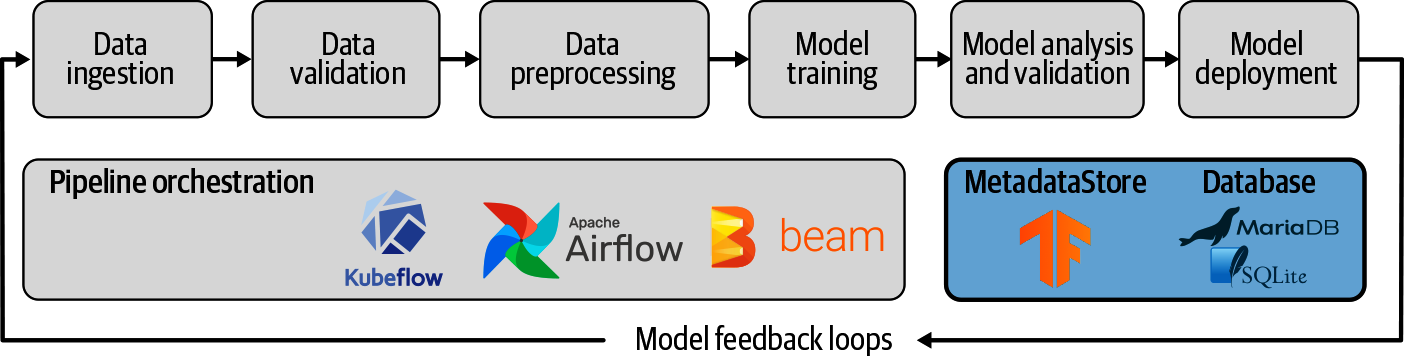

###### TFX Key Concepts

###### Pipeline
A TFX pipeline is a portable implementation of an ML workflow that can be run on various orchestrators, such as: Apache Airflow, Apache Beam, and Kubeflow Pipelines. A pipeline is composed of component instances and input parameters.


###### Component
A component is an implementation of an ML task that you can use as a step in your TFX pipeline. Components are composed of:

    A component specification, which defines the component's input and output artifacts, and the component's 
    required parameters.

    An executor, which implements the code to perform a step in your ML workflow, such as ingesting and 
    transforming data or training and evaluating a model.

    A component interface, which packages the component specification and executor for use in a pipeline.
    
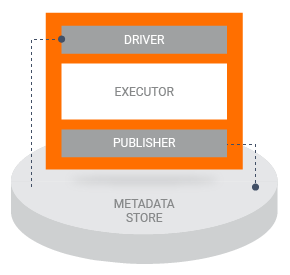

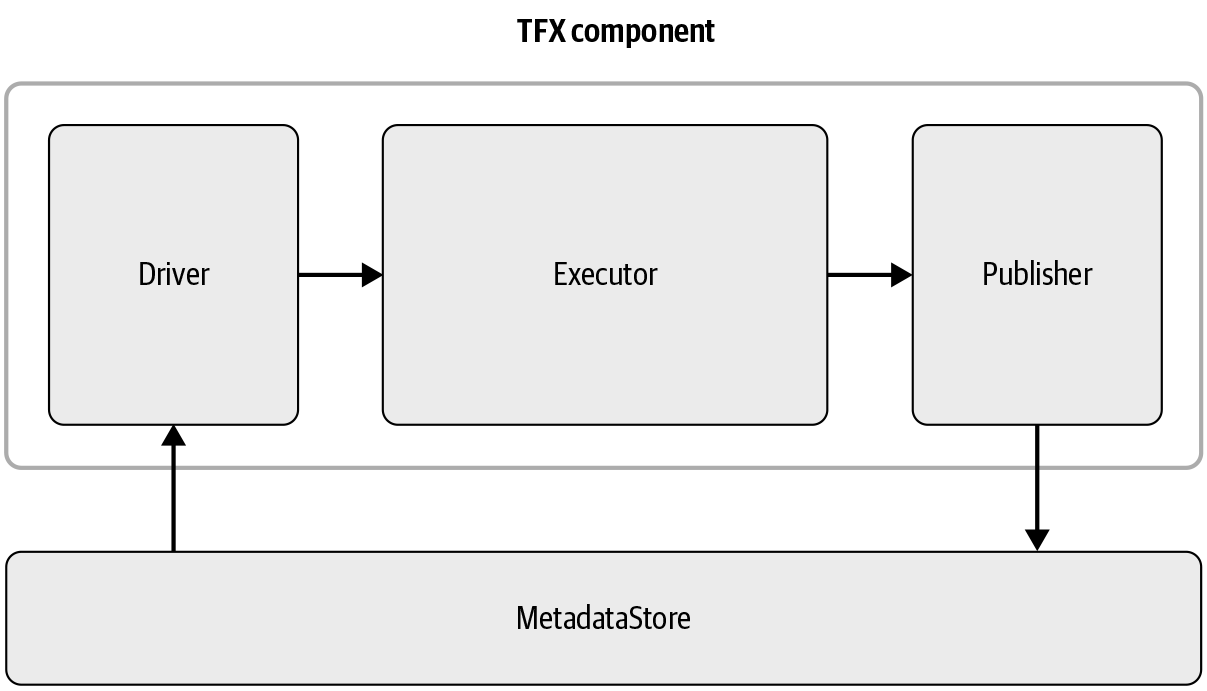

###### Parameter
Parameters are inputs to pipelines that are known before your pipeline is executed. Parameters let you change the behavior of a pipeline, or a part of a pipeline, through configuration instead of code.

For example, you can use parameters to run a pipeline with different sets of hyperparameters without changing the pipeline's code.

###### Artifact
The outputs of steps in a TFX pipeline are called artifacts. Subsequent steps in your workflow may use these artifacts as inputs. In this way, TFX lets you transfer data between workflow steps.



####  TFX Components

    1. ExampleGen
    2. StatisticsGen
    3. SchemaGen
    4. ExampleValidator
    5. Transform
    6. Trainer
    7. Tuner
    8. Evaluator
    9. InfraValidator
    10.Pusher
    11.BulkInferrer
    
    
    

In [ ]:
import os
import tempfile
import time

import tensorflow as tf
import tensorflow_data_validation as tfdv
import tensorflow_model_analysis as tfma
import tensorflow_transform as tft
import tfx
from tfx.components.trainer.executor import GenericExecutor
from tfx import components

from pprint import pprint
from tensorflow_metadata.proto.v0 import schema_pb2, statistics_pb2, anomalies_pb2
from tensorflow_transform.tf_metadata import schema_utils
from tfx.components import CsvExampleGen
from tfx.components import Evaluator
from tfx.components import ExampleValidator
from tfx.components import InfraValidator
from tfx.components import Pusher
from tfx.components import ResolverNode
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import Transform
from tfx.components.base import executor_spec
from tfx.components.common_nodes.importer_node import ImporterNode
from tfx.components.trainer import executor as trainer_executor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import evaluator_pb2
from tfx.proto import example_gen_pb2
from tfx.proto import infra_validator_pb2
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.proto.evaluator_pb2 import SingleSlicingSpec
from tfx.utils.dsl_utils import external_input
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing
from tfx.types.standard_artifacts import InfraBlessing
from tfx.extensions.google_cloud_ai_platform.tuner.component import Tuner

##### Creating Interactive Context

TFX Interactive Context allows you to create and run TFX Components in an interactive mode. It is designed to support experimentation and development in a Jupyter Notebook environment. It is an experimental feature and major changes to interface and functionality are expected. When creating the interactive context you can specifiy the following parameters:

    pipeline_name - Optional name of the pipeline for ML Metadata tracking purposes. If not specified, a
                    name will be generated for you.
    pipeline_root - Optional path to the root of the pipeline's outputs. If not specified, an ephemeral 
                    temporary directory will be created and used.
    metadata_connection_config - Optional metadata_store_pb2.ConnectionConfig instance used to configure 
                                 connection to a ML Metadata connection. If not specified, an ephemeral
                                 SQLite MLMD connection contained in the pipeline_root directory with file 
                                 name "metadata.sqlite" will be used.

In [ ]:
ARTIFACT_STORE = os.path.join(os.sep, 'Users', 'ukannika', 'work',  'artifact-store')
DATA_ROOT = '/Users/ukannika/work/imdb'

PIPELINE_NAME = 'tfx-pipeline-imdb-project'
PIPELINE_ROOT = os.path.join(ARTIFACT_STORE, PIPELINE_NAME, time.strftime("%Y%m%d_%H%M%S"))
os.makedirs(PIPELINE_ROOT, exist_ok=True)

context = InteractiveContext(
    pipeline_name=PIPELINE_NAME,
    pipeline_root=PIPELINE_ROOT,
    metadata_connection_config=None
)

In [ ]:
SERVING_MODEL_DIR = os.path.join(os.sep, 'Users', 'ukannika', 'work',  'artifact-store', 'model-serving')

**ExampleGen:**

    The ExampleGen TFX Pipeline component ingests data into TFX pipelines.
    
    Input[Consumes]: Data from external data sources such as CSV, TFRecord, Avro, Parquet and BigQuery.
      Output[Emits]: tf.Example records, tf.SequenceExample records, or proto format, depending on the payload 
                     format. 


###### Data Preparation

ExampleGen components allows us to configure input settings (input_config) and output settings (output_config) for our dataset.

**Splitting Datasets:** Used when we want to evaluate our machine learning model during the training and test it during the model analysis step. Therefore, it is beneficial to split the dataset into the required subsets.


<code> output = example_gen_pb2.Output(
            split_config=example_gen_pb2.SplitConfig(splits=[ 
            example_gen_pb2.SplitConfig.Split(name='train', hash_buckets=6), 
            example_gen_pb2.SplitConfig.Split(name='eval', hash_buckets=2),
            example_gen_pb2.SplitConfig.Split(name='test', hash_buckets=2)
        ]))

    examples = external_input(os.path.join(base_dir, data_dir))
    example_gen = CsvExampleGen(input=examples, output_config=output) 
</code>


**Spanning Datasets:** One of the significant use cases for machine learning pipelines is that we can update our machine learning models when new data becomes available. For this scenario, the ExampleGen component allows us to use spans. Think of a span as a snapshot of data. Every hour, day, or week, a batch extract, transform, load (ETL) process could make such a data snapshot and create a new span.

<code> input = example_gen_pb2.Input(splits=[
                example_gen_pb2.Input.Split(pattern='export-{SPAN}/*')])
    
       examples = external_input(os.path.join(base_dir, data_dir))
       example_gen = CsvExampleGen(input=examples, input_config=input)
       context.run(example_gen)
</code>

In [ ]:
# Configure and run CsvExampleGen. 
# The component is configured to split the input data into two splits - train and eval - using 4:1 ratio.
output_config = example_gen_pb2.Output(
    split_config=example_gen_pb2.SplitConfig(splits=[
        example_gen_pb2.SplitConfig.Split(name='train', hash_buckets=9),
        example_gen_pb2.SplitConfig.Split(name='eval', hash_buckets=1)
    ]))


example_gen = tfx.components.CsvExampleGen(
    input_base=DATA_ROOT,
    output_config=output_config
)

In [ ]:
# Use InteractiveContext to run it locally on notebook.
context.run(example_gen)

###### Examine the ingested data


In [ ]:
examples_uri = example_gen.outputs['examples'].get()[0].uri
tfrecord_filenames = [os.path.join(examples_uri, 'train', name)
                      for name in os.listdir(os.path.join(examples_uri, 'train'))]
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
for tfrecord in dataset.take(2):
    example = tf.train.Example()
    example.ParseFromString(tfrecord.numpy())
    for name, feature in example.features.feature.items():
        if feature.HasField('bytes_list'):
            value = feature.bytes_list.value
        if feature.HasField('float_list'):
            value = feature.float_list.value
        if feature.HasField('int64_list'):
            value = feature.int64_list.value
        print('{}: {}'.format(name, value))
    print('******')

###### StatisticsGen

The StatisticsGen TFX pipeline component generates features statistics over both training and serving data, which can be used by other pipeline components. StatisticsGen uses Beam to scale to large datasets.

    Consumes: datasets created by an ExampleGen pipeline component.
    Emits: Dataset statistics.
    
If our goal is to automate our machine learning model updates, validating our data is essential. In particular, when we say validating, we mean three distinct checks on our data:

    Check for data anomalies.

    Check that the data schema hasn’t changed.

    Check that the statistics of our new datasets still align with statistics from our previous training datasets.



In [ ]:
statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'],
      instance_name='Statistics_Generation'
      )

In [ ]:
context.run(statistics_gen)

The generated statistics can be visualized using the tfdv.visualize_statistics() function from the TensorFlow Data Validation library or using a utility method of the InteractiveContext object. In fact, most of the artifacts generated by the TFX components can be visualized using InteractiveContext.

In [ ]:
context.show(statistics_gen.outputs['statistics'])

###### SchemaGen

 The schema is an instance of schema.proto. It can specify data types for feature values, whether a feature has to be present in all examples, allowed value ranges, and other properties. A SchemaGen pipeline component will automatically generate a schema by inferring types, categories, and ranges from the training data.

    Consumes: statistics from a StatisticsGen component
    Emits: Data schema proto

In [ ]:
schema_gen = tfx.components.SchemaGen(
    statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)

In [ ]:
context.run(schema_gen)

# Visualize the schema.
context.show(schema_gen.outputs['schema'])

##### ExampleValidator

The ExampleValidator pipeline component identifies anomalies in training and serving data. It can detect different classes of anomalies in the data. For example it can:

    1. perform validity checks by comparing data statistics against a schema that codifies expectations of the user
    2. detect training-serving skew by comparing training and serving data.
    3. detect data drift by looking at a series of data.

The ExampleValidator pipeline component identifies any anomalies in the example data by comparing data statistics computed by the StatisticsGen pipeline component against a schema. The inferred schema codifies properties which the input data is expected to satisfy, and can be modified by the developer.

    Consumes: A schema from a SchemaGen component, and statistics from a StatisticsGen component.
    Emits: Validation results

In [ ]:
example_validator = tfx.components.ExampleValidator(
      statistics=statistics_gen.outputs['statistics'],
      schema=schema_gen.outputs['schema'],
      instance_name="Data_Validation"
      )

In [ ]:
context.run(example_validator)

In [ ]:
# Examine the output of validator.
context.show(example_validator.outputs['output'])

###### Transform [Preprocessing Stage]

The Transform TFX pipeline component performs feature engineering on tf.Examples emitted from an ExampleGen component, using a data schema created by a SchemaGen component, and emits a SavedModel. When executed, the SavedModel will accept tf.Examples emitted from an ExampleGen component and emit the transformed feature data.

    Consumes: tf.Examples from an ExampleGen component, and a data schema from a SchemaGen component.
    Emits: A SavedModel to a Trainer component

In [ ]:
TRANSFORM_MODULE = 'preprocessing.py'

In [ ]:
transform = tfx.components.Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=TRANSFORM_MODULE)

In [ ]:
context.run(transform)

###### Examine the Transform component's outputs

The Transform component has 2 outputs:

    transform_graph - contains the graph that can perform the preprocessing operations (this graph will be 
                      included in the serving and evaluation models).
    transformed_examples - contains the preprocessed training and evaluation data.

Take a peek at the transform_graph artifact: it points to a directory containing 3 subdirectories:


In [ ]:
os.listdir(transform.outputs['transform_graph'].get()[0].uri)

In [ ]:
os.listdir(transform.outputs['transformed_examples'].get()[0].uri)

In [ ]:
transform_uri = transform.outputs['transformed_examples'].get()[0].uri
tfrecord_filenames = [os.path.join(transform_uri,  'train', name)
                      for name in os.listdir(os.path.join(transform_uri, 'train'))]

dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
for tfrecord in dataset.take(2):
    example = tf.train.Example()
    example.ParseFromString(tfrecord.numpy())
    for name, feature in example.features.feature.items():
        if feature.HasField('bytes_list'):
            value = feature.bytes_list.value
        if feature.HasField('float_list'):
            value = feature.float_list.value
        if feature.HasField('int64_list'):
            value = feature.int64_list.value
        print('{}: {}'.format(name, value))
    print('******')

In [ ]:
transform_uri = transform.outputs['transformed_examples'].get()[0].uri
tfrecord_filenames = [os.path.join(transform_uri,  'eval', name)
                      for name in os.listdir(os.path.join(transform_uri, 'eval'))]

dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
for tfrecord in dataset.take(2):
    example = tf.train.Example()
    example.ParseFromString(tfrecord.numpy())
    for name, feature in example.features.feature.items():
        if feature.HasField('bytes_list'):
            value = feature.bytes_list.value
        if feature.HasField('float_list'):
            value = feature.float_list.value
        if feature.HasField('int64_list'):
            value = feature.int64_list.value
        print('{}: {}'.format(name, value))
    print('******')

#### Trainer

**Trainer takes**:

    tf.Examples used for training and eval. 
    
    A user provided module file that defines the trainer logic.
    
    A data schema created by a SchemaGen pipeline component and optionally altered by the developer.
    
    Protobuf definition of train args and eval args.
    
    (Optional) transform graph produced by an upstream Transform component.
    
    (Optional) pre-trained models used for scenarios such as warmstart.
    
    (Optional) hyperparameters, which will be passed to user module function. Details of the integration 
    with Tuner can be found here.
    
**Trainer emits:** At least one model for inference/serving (typically in SavedModelFormat) and optionally another model for eval (typically an EvalSavedModel).

We provide support for alternate model formats such as TFLite through the Model Rewriting Library. See the link to the Model Rewriting Library for examples of how to convert both Estimator and Keras models.



To configure Trainer, you need to encapsulate your training code in a Python module that is then provided to the Trainer as an input.



The **run_fn()** function is a generic entry point to the training steps and not tf.Keras specific. It carries out the following steps:

    Loading the training and validation data (or the data generator)

    Defining the model architecture and compiling the model

    Training the model

    Exporting the model to be evaluated in the next pipeline step



In [ ]:
TRAINER_MODULE_FILE = 'train.py'

In [ ]:
trainer = Trainer(
      module_file=TRAINER_MODULE_FILE,
      custom_executor_spec=tfx.dsl.components.base.executor_spec.ExecutorClassSpec(GenericExecutor),
      examples=transform.outputs['transformed_examples'],
      transform_graph=transform.outputs['transform_graph'],
      schema=schema_gen.outputs['schema'],
      train_args=trainer_pb2.TrainArgs(num_steps=500),
      eval_args=trainer_pb2.EvalArgs(num_steps=200))


In [ ]:
context.run(trainer)

###### The Tuner TFX Pipeline Component

The Tuner component tunes the hyperparameters for the model.

Tuner takes:

    tf.Examples used for training and eval.

    A user provided module file (or module fn) that defines the tuning logic, including model 
    definition, hyperparameter search space, objective etc.
    
    Protobuf definition of train args and eval args.
    
    (Optional) Protobuf definition of tuning args.
    
    (Optional) transform graph produced by an upstream Transform component.
    
    (Optional) A data schema created by a SchemaGen pipeline component and optionally altered by the developer.

With the given data, model, and objective, Tuner tunes the hyperparameters and emits the best result.

In [ ]:
tuner = Tuner(
    module_file=TRAINER_MODULE_FILE,  # Contains `tuner_fn`.
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    train_args=trainer_pb2.TrainArgs(num_steps=20),
    eval_args=trainer_pb2.EvalArgs(num_steps=5))

In [ ]:
trainer = Trainer(
      module_file=TRAINER_MODULE_FILE,
      custom_executor_spec=tfx.dsl.components.base.executor_spec.ExecutorClassSpec(GenericExecutor),
      examples=transform.outputs['transformed_examples'],
      transform_graph=transform.outputs['transform_graph'],
      hyperparameters=tuner.outputs['best_hyperparameters'],
      schema=schema_gen.outputs['schema'],
      train_args=trainer_pb2.TrainArgs(num_steps=500),
      eval_args=trainer_pb2.EvalArgs(num_steps=200))

In [ ]:
context.run(trainer)

**At this point in our machine learning pipeline,** we have checked the statistics of our data, we have transformed our data into the correct features, and we have trained our model. Surely now it’s time to put the model into production? In our opinion, there should be two extra steps before you move on to deploy your model: analyzing your model’s performance in-depth and checking that it will be an improvement on any model that’s already in production. 

##### The Evaluator TFX Pipeline Component

The Evaluator TFX pipeline component performs deep analysis on the training results for your models, to help you understand how your model performs on subsets of your data. The Evaluator also helps you validate your exported models, ensuring that they are "good enough" to be pushed to production.

When validation is enabled, the Evaluator compares new models against a baseline (such as the currently serving model) to determine if they're "good enough" relative to the baseline. It does so by evaluating both models on an eval dataset and computing their performance on metrics (e.g. AUC, loss). If the new model's metrics meet developer-specified criteria relative to the baseline model (e.g. AUC is not lower), the model is "blessed" (marked as good), indicating to the Pusher that it is ok to push the model to production.

Consumes:

    An eval split from ExampleGen
    A trained model from Trainer
    A previously blessed model (if validation to be performed)
    
Emits:

    Analysis results to ML Metadata
    Validation results to ML Metadata (if validation to be performed)

###### TFMA [TensorFlow Model Analysis]

TFMA gives us an easy way to get more detailed metrics than just those used during model training. It lets us visualize metrics as time series across model versions, and it gives us the ability to view metrics on slices of a dataset. It also scales easily to large evaluation sets thanks to Apache Beam.


**ResolverNodes**

A Resolver component is required if we want to compare a new model against a previous model. ResolverNodes are generic components that query the metadata store. In this case, we use the latest_blessed_model_resolver. It checks for the last blessed model and returns it as a baseline so it can be passed on to the Evaluator component with the new candidate model. The Resolver is not needed if we don’t want to validate our model against a threshold of some metric, but we highly recommend this step. If you don’t validate the new model, it will automatically get pushed to the serving directory, even if its performance is worse than that of the previous model. On the first run of the Evaluator when there is no blessed model, the Evaluator automatically blesses the model.

In [ ]:
model_resolver = ResolverNode(
      instance_name='latest_blessed_model_resolver',
      resolver_class=latest_blessed_model_resolver.LatestBlessedModelResolver,
      model=Channel(type=Model),
      model_blessing=Channel(type=ModelBlessing))

context.run(model_resolver)

In [ ]:
model_resolver.outputs

In [ ]:
# Define thresholds.
accuracy_threshold = tfma.MetricThreshold(
                value_threshold=tfma.GenericValueThreshold(
                    lower_bound={'value': 0.4},
                    upper_bound={'value': 0.99}),
                change_threshold=tfma.GenericChangeThreshold(
                    absolute={'value': 0.0001},
                    direction=tfma.MetricDirection.HIGHER_IS_BETTER),
                )

metrics_specs = tfma.MetricsSpec(
                   metrics = [
                       tfma.MetricConfig(class_name='BinaryAccuracy', threshold=accuracy_threshold)])

eval_config = tfma.EvalConfig(
    model_specs=[
        tfma.ModelSpec(label_key='label')
    ],
    metrics_specs=[metrics_specs],
    slicing_specs=[
        tfma.SlicingSpec()
    ]
)
eval_config

In [ ]:
model_analyzer = Evaluator(
    examples=example_gen.outputs.examples,
    model=trainer.outputs.model,
    baseline_model=model_resolver.outputs.model,
    eval_config=eval_config
)
context.run(model_analyzer, enable_cache=False)

In [ ]:
eval_result = model_analyzer.outputs['evaluation'].get()[0].uri
tfma_result = tfma.load_eval_result(eval_result)

In [ ]:
print(tfma_result)

#### Visualize evaluation results

You can visualize the evaluation results using the tfma.view.render_slicing_metrics() function from TensorFlow Model Analysis library.

Setup Note: Currently, TFMA visualizations don't render in JupyterLab. Make sure that you run this notebook in Classic Notebook.

In [ ]:
evaluation_uri = evaluator.outputs['evaluation'].get()[0].uri
evaluation_uri
!ls {evaluation_uri}

In [ ]:
eval_result = tfma.load_eval_result(evaluation_uri)
eval_result

In [ ]:
tfma.view.render_slicing_metrics(eval_result)

##### InfraValidator

InfraValidator is a TFX component that is used as an early warning layer before pushing a model into production. The name "infra" validator came from the fact that it is validating the model in the actual model serving "infrastructure". If Evaluator is to guarantee the performance of the model, InfraValidator is to guarantee the model is mechanically fine and prevents bad models from being pushed.


InfraValidator takes the model, launches a sand-boxed model server with the model, and sees if it can be successfully loaded and optionally queried. The infra validation result will be generated in the blessing output in the same way as Evaluator does.

Depending on the configuration, infra validation is done in one of the following modes:

    LOAD_ONLY mode: checking whether the model was successfully loaded in the serving infrastructure or not. OR
    LOAD_AND_QUERY mode: LOAD_ONLY mode plus sending some sample requests to check if model is capable of 
                         serving inferences. InfraValidator does not care the prediction was correct or not. 
                         Only whether the request was successful or not matters.

In [ ]:
infra_validator = InfraValidator(
    model=trainer.outputs['model'],
    examples=example_gen.outputs['examples'],
    serving_spec=infra_validator_pb2.ServingSpec(
        tensorflow_serving=infra_validator_pb2.TensorFlowServing(
            tags=['latest']),
      local_docker=infra_validator_pb2.LocalDockerConfig(),
  ),
    validation_spec=infra_validator_pb2.ValidationSpec(
        max_loading_time_seconds=60,
        num_tries=5,
    ),    
  request_spec=infra_validator_pb2.RequestSpec(
      tensorflow_serving=infra_validator_pb2.TensorFlowServingRequestSpec(),
          num_examples=5,
      )
)

In [ ]:
context.run(infra_validator, enable_cache=False)

In [ ]:
infra_blessing_uri = infra_validator.outputs.blessing.get()[0].uri
!ls -l {infra_blessing_uri}

###### TFX Pusher Component

The Pusher component is used to push a validated model to a deployment target during model training or re-training. Before the deployment, Pusher relies on one or more blessings from other validation components to decide whether to push the model or not.

    Evaluator blesses the model if the new trained model is "good enough" to be pushed to production.
    
    (Optional but recommended) InfraValidator blesses the model if the model is mechanically servable in a 
    production environment.
    
    A Pusher component consumes a trained model in SavedModel format, and produces the same SavedModel, along 
    with versioning metadata.
    

In [ ]:
pusher = components.Pusher(
  model=trainer.outputs['model'],
  model_blessing=model_analyzer.outputs['blessing'],
  infra_blessing=infra_validator.outputs['blessing'],
  push_destination=pusher_pb2.PushDestination(
    filesystem=pusher_pb2.PushDestination.Filesystem(
        base_directory=SERVING_MODEL_DIR)
  )
)

context.run(pusher)

**ExampleGen** => *Ingests the new data from the data source we wish to use*

**StatisticsGen** => *Calculates the summary statistics of the new data*

**SchemaGen** => *Defines the expected features for the model, as well as their types and ranges*

**ExampleValidator** => *Checks the data against the schema and flags any anomalies*

**Transform** => *Preprocesses the data into the correct numerical representation that the model is expecting*

**Trainer** => *Trains the model on the new data*

**Resolver** => *Checks for the presence of a previously blessed model and returns it for comparison* 

**Evaluator** => *Evaluates the model’s performance on an evaluation dataset and validates the model if it is
                 an improvement on the previous version*

**Pusher** => *Pushes the model to a serving directory if it passes the validation step*

**Serving** => *Serves the model for user requests [Deployed as webservice]*


In [ ]:
# You can use Tensorflow serving to deploy these models into Tensorflow serving. 